In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs6 import *
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
cohort = 'basel'
ss = 10

In [3]:
tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))
pretty_printing = np.hstack([tr_exp.var_names, 'size'])

In [4]:
#nc = len(analysisProteins)
batchSize = 128
learnRate = 1e-3
nm = 'student'
rr = 1
rv = 10 #1000 
r = 0

In [5]:
## compute training and test set
#trY, trS = prepData(tr_exp, 1, analysisProteins) ## inc cell sizes
#teY, teS = prepData(te_exp, 1, analysisProteins) ## inc cell sizes

trY, trS = prepData(tr_exp, 1) ## inc cell sizes
teY, teS = prepData(te_exp, 1) ## inc cell sizes

trFY, trFS, trFL = simulate_data(trY, trS, 1) ## relax rule
teFY, teFS, teFL = simulate_data(teY, teS, 1) ## relax rule

trMat = np.hstack((trY, trS.reshape(-1,1)))
teMat = np.hstack((teY, teS.reshape(-1,1)))
trFMat = np.hstack((trFY, trFS.reshape(-1,1)))
teFMat = np.hstack((teFY, teFS.reshape(-1,1)))
df = ConcatDataset(trY, trS, trFY, trFS, trFL)

In [6]:
trMat.dtype

dtype('float64')

# PhenoGraph

In [7]:
#import phenograph
import scanpy.external as sce
pheno_labels, _, _ = sce.tl.phenograph(trMat)
tr_exp.obs['pheno_label'] = pheno_labels.astype(str)

## set number of clusters
nc = len(np.unique(pheno_labels))
pheno_centers = np.zeros((nc, trMat.shape[1]))
for k in range(nc):
    pheno_centers[k,:] = trMat[pheno_labels==k].mean(0)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.798640966415405 seconds
Jaccard graph constructed in 1.5349862575531006 seconds
Wrote graph to binary file in 0.3280177116394043 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.821201
After 4 runs, maximum modularity is Q = 0.823021
Louvain completed 24 runs in 6.919469118118286 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 15.860607624053955 seconds


In [8]:
tr_exp.obs['pheno_label'].value_counts()

0     915
1     851
2     837
3     733
4     662
5     650
6     643
7     603
8     572
9     544
10    530
11    494
12    374
13    367
14    301
15    231
16    226
17    209
18    177
19     81
Name: pheno_label, dtype: int64

In [9]:
nc

20

# FlowSOM

In [10]:
from flowsom import flowsom as flowsom
from sklearn.cluster import AgglomerativeClustering

oPath = '/home/campbell/yulee/DAMM/new/res/{}/{}k/ex1/'.format(cohort, ss)
fs_fn = oPath + 'fsom1t_nc{}_{}_rv{}_rr{}_{}.csv'.format(nc, nm, rv, rr, r)
pd.DataFrame(np.array(trMat), columns = pretty_printing).to_csv(fs_fn)
fsom = flowsom(fs_fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

#fn = oPath + 'fsom1.csv'
#fsom = flowsom(fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

fsom.som_mapping(50, # x_n: e.g. 100, the dimension of expected map
       50, # y_n: e.g. 100, the dimension of expected map
       fsom.df.shape[1],
       1, # sigma: e.g 1, the standard deviation of initialized weights
       0.5, # lr: e.g 0.5, learning rate
       1000, # batch_size: 1000, iteration times
       tf_str=None, # string, e.g. hlog', None, etc - the transform algorithm
       if_fcs=False # bool, whethe the imput file is fcs file. If not, it should be a csv file
       # seed = 10, for reproducing
      )

start = nc; fsom_nc = 0
while fsom_nc < nc:
    print(nc, start, fsom_nc)
    fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=10) # train the meta clustering for cluster in range(40,45)  

    fsom.labeling()
    #fsom.bestk # the best number of clusters within the range of (min_n, max_n)
    fsom_class = np.unique(fsom.df['category'])
    fsom_nc = len(fsom_class)
    start += 1
    
fsom_labels = np.array(fsom.df['category'])
fsom_sorted_by_count = pd.Series(fsom_labels).value_counts().index

tr_exp.obs['fsom_label'] = 0
for i, val in enumerate(fsom_sorted_by_count):
    idx = fsom_labels == val
    tr_exp.obs['fsom_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['fsom_label'] = tr_exp.obs['fsom_label'].astype(str)

#fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=5)
fsom_centers = np.zeros((max(fsom_class)+1, fsom.df.shape[1]))
for row in range(max(fsom_class)+1):
    fsom_centers[row,:] = fsom.df[fsom_labels==row].mean(0)

fsom_centers = fsom_centers[fsom_sorted_by_count]
fs_centers = fsom_centers[:,:-1]
#pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])
#pd.DataFrame(out_center, columns = fsom.df.columns[:-1]).to_csv(oName)
#fsom.df['category'].to_csv(oPath + 'fsom{}_label_nc{}.csv'.format(cs, fsom_nc))

Training...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 18.09309828051699

...ready!
20 20 0
0 samples done...


/tmp/ipykernel_26040/121609084.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['fsom_label'].iloc[idx] = str(i)


In [11]:
tr_exp.obs['fsom_label'].value_counts()

0     1369
1     1071
2      956
3      926
4      874
5      827
6      574
7      542
8      534
9      505
10     399
11     327
12     284
13     243
14     222
15     122
16     101
17      53
18      37
19      34
Name: fsom_label, dtype: int64

# Random Forest

In [12]:
## run random forest
rf = RandomForestClassifier()
rf.fit(trFMat, trFL)

## save classifiers
#joblib.dump(rf, orf_classifier)

## compute random forest performance of simulated data (confusion matrix)
rf_p_fake_singlet = rf.predict_proba(teFMat)[:,1]
rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec = evalM(rf_p_fake_singlet, teFL)

In [13]:
rf1

0.8128631536766179

# Kmeans Initalization

In [14]:
## damm initialization
Theta0, okms_labels, okms_centers = kmeans_init1(trMat, 1, nc) ## inc cell sizes

## save kmeans results as damm initialization
#torch.save(Theta, output_theta0)

## save kmeans labels (in anndata object)
okms_sorted_by_count = pd.Series(okms_labels).value_counts().index

tr_exp.obs['kms_label'] = 0
for i, val in enumerate(okms_sorted_by_count):
    idx = okms_labels == val
    tr_exp.obs['kms_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['kms_label'] = tr_exp.obs['kms_label'].astype(str)

## save kmeans centers
okms_centers = okms_centers[okms_sorted_by_count]
#pd.DataFrame(okms_centers, columns = pretty_printing).to_csv(ookms_centers)

/tmp/ipykernel_26040/4079753086.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['kms_label'].iloc[idx] = str(i)


In [15]:
tr_exp.obs['kms_label'].value_counts()

0     1225
1     1157
2     1131
3      955
4      724
5      706
6      644
7      539
8      469
9      460
10     416
11     273
12     264
13     239
14     191
15     165
16     136
17     119
18     108
19      79
Name: kms_label, dtype: int64

## RF on Kmeans

In [16]:
#singlet_indices = np.where(rf.predict_proba(okms_centers)[:,0] <= 0.5)[0]
#Theta1 = {k: v.detach()[singlet_indices].requires_grad_(True) for (k,v) in Theta0.items()}
#Theta1['is_tau'] = Theta1['is_tau'].detach()[:,np.r_[singlet_indices]].requires_grad_(True)

# DAMM

In [17]:
loss, Theta1 = trainWFD(df, rr, Theta0, batchSize, nm, learnRate, rv)

/home/campbell/yulee/DAMM/new/code/pro/funcs6.py:237: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  ccmax = torch.combinations(psi).max(1).values


## Loss Curve

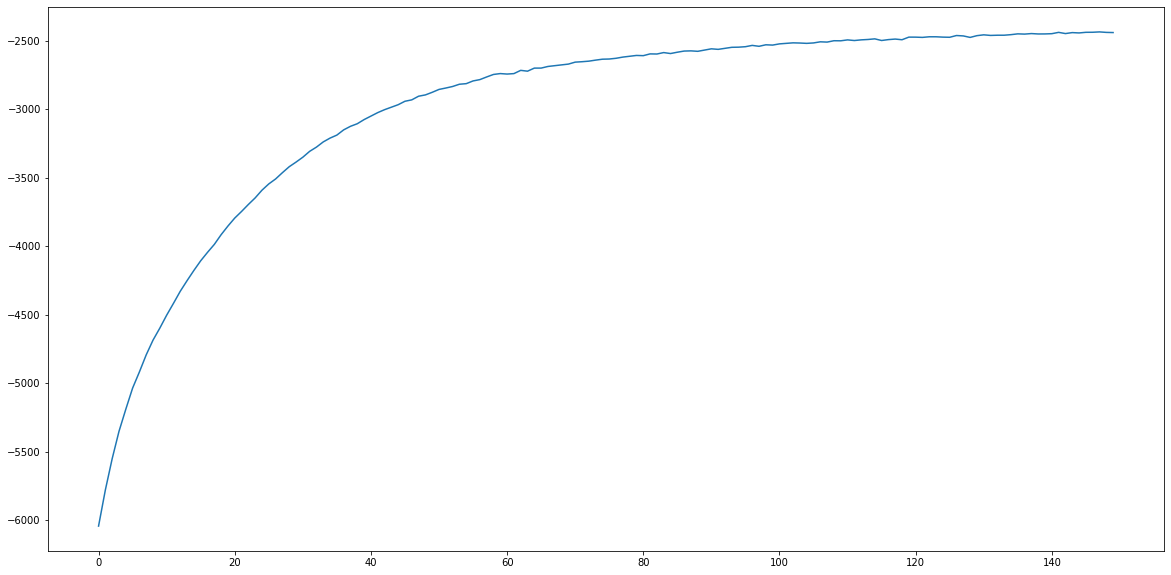

In [18]:
## total loss
plt.plot(np.array(loss)[:,0])

## Label

In [19]:
## output model parameters
#torch.save([loss, Theta], output_theta1)

## damm's doublet performance
with torch.no_grad():
    
    pred_loader = torch.utils.data.DataLoader(ConcatDataset(teFY, teFS), batch_size = 5000, shuffle = False)
    
    damm_p_fake_singlets = []
    for i, bat in enumerate(pred_loader):
        _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(bat[0], bat[1], Theta1, nm, rr)
        damm_p_fake_singlets.append(damm_p_fake_singlet)
        
    ## compute damm performance of simulated data (confusion matrix)
    dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec = evalM(torch.hstack(damm_p_fake_singlets), teFL)
    
    iter_out = [nc, nm, rv, rr, r, 
        rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec,
        dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec]

    ## output doublet performances
    #pd.Series(iter_out).to_csv(odoublet_performance)
    
    ## DAMM label
    damm_pred_singlet_label, damm_pred_singlet_cluster_assig_label, _ = get_assign_labels1(trY, trS, rr, Theta1, nm)    
    damm_sorted_by_count = pd.Series(damm_pred_singlet_cluster_assig_label).value_counts().index
    
    if len(damm_sorted_by_count) != nc:
        damm_sorted_by_count = np.hstack((damm_sorted_by_count, np.setdiff1d(range(nc), damm_sorted_by_count)))
        
    ## save damm labels
    damm_label = np.zeros(trY.shape[0]) + 50
    damm_label[damm_pred_singlet_label == 0] = damm_pred_singlet_cluster_assig_label
    
    #tr_exp.obs['damm_label'] = 50 #len(np.unique(damm_pred_singlet_cluster_assig_label))
    #tr_exp.obs.iloc[np.where(damm_pred_singlet_label == 0)[0],-1] = damm_pred_singlet_cluster_assig_label
    
    ## sorted labels by clusters
    tr_exp.obs['damm_label'] = 50
    for i, val in enumerate(damm_sorted_by_count):
        idx = damm_label == val
        tr_exp.obs['damm_label'].iloc[idx] = str(i)
    tr_exp.obs['damm_label'] = tr_exp.obs['damm_label'].astype(str)

    ## save damm centers
    damm_centers = np.array(torch.hstack([Theta1['log_mu'], Theta1['log_psi'].reshape(-1,1)]).exp())
    damm_centers = damm_centers[damm_sorted_by_count]
    #pd.DataFrame(damm_centers, columns = pretty_printing).to_csv(odamm_centers)

    ## output phenograph/kmeans/damm labels
    #tr_exp.obs.iloc[:,5:].to_csv(olabels)

/tmp/ipykernel_26040/2720189160.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['damm_label'].iloc[idx] = str(i)


In [20]:
tr_exp.obs['damm_label'].value_counts()

50    1853
0     1621
1     1481
2     1299
3     1162
4     1032
5      634
6      282
7      132
8      110
9      100
10      78
11      74
12      46
13      38
14      20
15      14
16       9
17       9
18       4
19       2
Name: damm_label, dtype: int64

## Doublet Probability

In [21]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta1, nm, rr)
tr_exp.obs['prob_doublet'] = 1 - p_singlet

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pheno_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fsom_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` pa

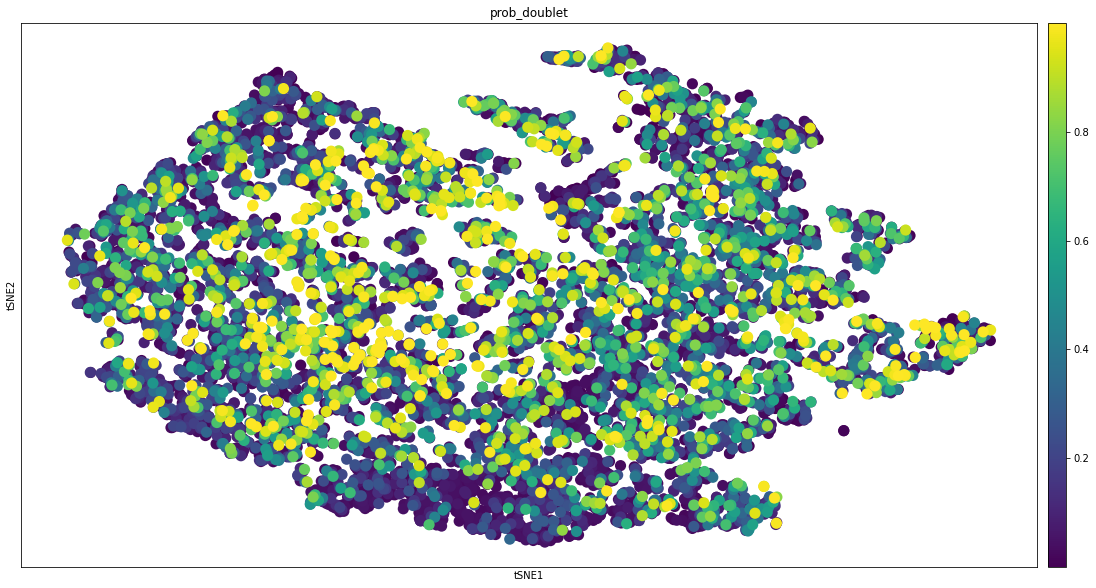

In [22]:
sc.tl.tsne(tr_exp)
sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [23]:
## compute neighbors for tsne
#sc.pp.scale(tr_exp, max_value=3)
#sc.tl.pca(tr_exp)
#sc.pp.neighbors(tr_exp, use_rep="X_pca")
#sc.tl.tsne(tr_exp)
#sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [24]:
sum(p_singlet.detach() > 0.5)

tensor(8147)

In [25]:
pd.DataFrame(pheno_centers, columns = pretty_printing)

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,KK14,SMA,...,S6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,14.168665,0.729111,0.164923,3.003161,0.995498,2.066486,0.298063,0.251179,0.212077,1.040327,...,3.574780,0.797321,0.138928,1.346947,0.331048,14.377712,1.179675,4.672272,8.871660,57.107104
1,11.541157,0.657274,0.159780,3.054701,1.154665,2.447780,0.284612,0.252137,0.225005,1.203666,...,3.495959,0.764113,0.137483,1.373349,0.377488,17.320345,1.163372,4.263259,8.060375,105.383079
2,7.939887,0.560258,0.129066,6.613049,0.279151,0.430922,0.241896,0.715558,0.175046,3.109021,...,2.701438,0.821446,0.157712,0.781887,0.091915,1.952691,0.822819,4.620296,8.767549,111.940263
3,5.379007,0.461915,0.127193,8.357994,0.283645,0.416459,0.205748,0.597107,0.159570,2.908801,...,2.411918,0.745390,0.150729,0.705959,0.081494,1.716891,0.709209,3.603670,6.820993,61.289222
4,8.237274,0.524219,0.131311,4.777193,0.723122,1.247622,0.216514,0.315628,0.147857,1.827798,...,2.727533,0.584904,0.109118,0.944493,0.215032,8.428598,0.833133,3.932459,7.424325,143.282477
5,5.079791,0.406074,0.089122,7.811590,0.237652,0.241806,0.160962,0.408391,0.105685,2.894788,...,1.961498,0.567613,0.105570,0.514986,0.059614,0.936028,0.517867,3.112295,5.930719,86.820000
6,8.314445,0.543047,0.137204,7.323676,0.315247,0.632645,0.246369,0.679619,0.191415,2.907167,...,2.904529,0.903427,0.149081,0.822610,0.123573,2.837027,0.845646,4.537743,8.595762,166.328149
7,4.322024,0.362261,0.104845,6.137882,0.329175,0.484535,0.151567,0.346053,0.108135,1.655458,...,1.962759,0.522673,0.098158,0.581944,0.101096,3.108717,0.608982,2.462039,4.567140,24.504146
8,11.814690,1.156206,0.276674,4.359821,3.141920,6.120921,0.418564,0.307610,0.357043,1.496653,...,4.578467,1.032616,0.221790,2.342179,1.059694,58.037911,1.667416,5.358380,10.107377,75.548951
9,11.874126,0.652719,0.133477,5.764960,0.269425,0.354682,0.271699,0.928783,0.211392,2.017804,...,3.268512,1.074245,0.183079,0.989674,0.107127,2.482044,1.061887,4.550606,8.670998,69.694853


In [26]:
pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,KK14,SMA,...,S6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,7.192790,0.513711,0.146730,5.473791,0.494744,0.812101,0.228047,0.497304,0.210626,4.318576,...,2.560711,0.668070,0.128025,0.799632,0.161101,4.776900,0.763821,3.862224,7.315257,89.577064
1,5.418307,0.394501,0.112027,5.946788,0.336830,0.457845,0.171242,0.325098,0.132203,2.012185,...,2.042624,0.563411,0.101623,0.620137,0.110715,2.598758,0.583816,3.465829,6.570494,68.550887
2,8.306307,0.551077,0.143762,4.725235,0.703463,1.304522,0.226646,0.368009,0.172053,1.920501,...,2.810469,0.700839,0.125875,0.955211,0.222697,8.948713,0.857567,4.235458,8.022835,146.476987
3,7.981379,0.552666,0.149787,6.262575,0.372763,0.570829,0.235464,0.540440,0.210145,5.028790,...,2.513691,0.751809,0.135574,0.748058,0.100795,2.698878,0.759012,3.817026,7.258857,44.430886
4,8.700737,0.631625,0.163305,5.100260,1.186631,1.862223,0.273960,0.383366,0.239020,3.259860,...,3.133319,0.774234,0.138666,1.169005,0.375426,16.489544,0.978451,4.040969,7.664538,192.479405
5,7.717150,0.515041,0.124686,5.450285,0.414229,0.731640,0.216007,0.482191,0.190829,2.319814,...,2.560784,0.747389,0.126587,0.823218,0.122722,3.984198,0.746788,3.944645,7.491739,120.264813
6,10.620982,0.716294,0.138711,7.641935,0.352589,0.483227,0.294226,1.013204,0.212356,2.886832,...,3.388219,1.042851,0.192448,1.004272,0.126363,3.159285,1.083972,4.672026,8.876030,61.243902
7,5.829452,0.423111,0.113088,6.282730,0.411705,0.694700,0.181913,0.345107,0.127583,1.835459,...,2.249412,0.593627,0.109039,0.701022,0.126643,4.452515,0.710336,2.863396,5.334526,23.422509
8,8.692242,0.607454,0.146386,7.885387,0.325504,0.525178,0.290284,0.927797,0.231421,4.450893,...,3.085267,1.007929,0.179849,0.877145,0.115610,2.229012,0.964476,4.557435,8.635577,112.507491
9,11.865498,0.781785,0.182962,3.200007,1.302895,2.922801,0.325422,0.305554,0.214791,1.333711,...,3.836761,0.829747,0.153178,1.523351,0.450859,20.507534,1.289759,4.123625,7.808980,58.782178


In [27]:
pd.DataFrame(okms_centers, columns = pretty_printing)

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,KK14,SMA,...,S6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,6.902061,0.472267,0.131754,5.976710,0.432980,0.718858,0.208174,0.415562,0.165181,3.266747,...,2.394043,0.627949,0.115998,0.754827,0.132040,3.947452,0.706271,3.661334,6.930402,74.638367
1,6.945530,0.484074,0.123951,5.827221,0.410542,0.703432,0.205790,0.454811,0.183978,3.007664,...,2.415249,0.653202,0.113275,0.738423,0.134034,3.780676,0.708592,3.801723,7.215410,103.115152
2,7.206952,0.483008,0.126736,4.926616,0.517601,0.928832,0.207905,0.355474,0.149104,2.474337,...,2.418905,0.594178,0.114547,0.790974,0.151193,5.659777,0.742662,3.557478,6.764961,51.016799
3,8.133551,0.521752,0.134912,5.022680,0.542953,1.007597,0.224677,0.411195,0.172999,2.875499,...,2.629015,0.650738,0.121915,0.863063,0.163771,6.146069,0.794737,3.946048,7.476213,132.381400
4,8.252212,0.547350,0.144049,5.158288,0.697989,1.179021,0.236582,0.410829,0.193383,2.506640,...,2.886278,0.726590,0.126243,0.971953,0.249651,7.760473,0.844536,4.286459,8.113524,167.321823
5,6.484989,0.473496,0.128689,5.941784,0.434357,0.744269,0.188060,0.375073,0.167600,2.376018,...,2.319021,0.632923,0.116294,0.699375,0.137751,4.846945,0.716727,3.167961,5.927060,23.961756
6,10.576865,0.703610,0.172612,7.249583,0.430888,0.681956,0.309549,0.864741,0.268697,5.004662,...,3.303993,0.983157,0.183370,1.021162,0.182662,4.597192,1.041452,4.764501,9.028837,87.270186
7,11.128510,0.698484,0.160312,6.952693,0.386744,0.743257,0.297767,0.806880,0.247008,3.795448,...,3.378141,1.088481,0.178130,1.029717,0.152806,4.521215,1.091404,4.423404,8.396281,45.797774
8,10.670775,0.641839,0.164077,7.518663,0.362281,0.793070,0.306434,0.851486,0.243079,3.394489,...,3.412851,1.128871,0.184413,1.035790,0.149663,4.287880,1.047911,4.934301,9.352064,138.358209
9,13.041191,0.884218,0.196991,3.581200,1.821898,3.738639,0.333260,0.252708,0.253294,1.659979,...,3.963063,0.877399,0.170176,1.808708,0.556885,30.519565,1.354778,4.752705,8.980243,95.191304


In [28]:
#pd.DataFrame(okms_centers[singlet_indices], columns = pretty_printing)

In [29]:
pd.DataFrame(damm_centers, columns = pretty_printing)

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,KK14,SMA,...,S6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,2.637466,0.267893,0.068783,4.802213,0.136332,0.096385,0.090661,0.131737,0.053844,0.339012,...,1.188719,0.171908,0.048818,0.301006,0.024107,0.174553,0.307711,2.568793,4.874169,72.030322
1,5.844195,0.401250,0.091503,1.016574,0.535856,0.915208,0.156343,0.119538,0.084137,0.188932,...,2.245293,0.286749,0.074772,0.725468,0.118195,8.659436,0.729267,3.012619,5.846358,68.528611
2,5.511016,0.411419,0.087720,4.766961,0.195602,0.137702,0.176580,0.403244,0.104625,1.141565,...,2.109712,0.382556,0.093451,0.583866,0.043561,0.211071,0.632240,3.147050,5.900357,53.131424
3,10.725534,0.677433,0.138610,1.558761,0.948627,2.632339,0.287528,0.187343,0.145021,0.273078,...,3.958985,0.447186,0.140544,1.278630,0.194066,21.246622,1.209176,3.770469,7.050272,84.566171
4,6.979600,0.495175,0.116281,5.511330,0.223111,0.208129,0.269120,0.528674,0.184368,0.986878,...,3.103517,0.604265,0.154176,0.907252,0.064157,0.465824,1.008316,3.229087,6.187182,66.149133
5,15.137839,1.052783,0.184476,1.828642,1.854591,5.157394,0.503828,0.253308,0.213804,0.317510,...,5.936510,0.763140,0.229214,2.309267,0.444650,35.295135,2.037362,4.938123,9.533171,80.991878
6,10.944159,0.796421,0.166186,5.910682,0.378271,0.347423,0.433995,0.979236,0.280332,2.346770,...,4.873302,1.119392,0.258754,1.399284,0.113361,2.062596,1.553344,3.920184,7.509646,69.104210
7,5.082704,0.451286,0.068610,5.942876,0.178218,0.161988,0.167578,0.307738,0.115041,2.056296,...,1.689875,0.544663,0.082591,0.397831,0.047191,0.440078,0.434342,3.193479,6.179353,114.540107
8,11.437669,0.714473,0.177673,7.446586,0.622577,0.841517,0.341132,0.338874,0.318324,3.946383,...,4.657373,0.820977,0.154146,1.195819,0.233483,12.723844,0.854582,5.167760,9.892666,82.974425
9,8.403684,1.305034,1.399863,2.845739,1.812285,3.024368,0.520377,0.604927,1.369986,6.523721,...,4.965745,1.094163,0.271174,2.336128,0.974611,22.464084,1.210244,7.879813,14.634998,75.553297


# Expression Heatmap (scaled)

In [30]:
scaler = MinMaxScaler()
#s2 = scaler.fit(np.vstack([pheno_centers, fsom_centers, okms_centers, okms_centers[singlet_indices], damm_centers]))
s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, okms_centers, damm_centers]))

#s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, damm_centers]))

## PhenoGraph

Text(156.0, 0.5, 'Cluster')

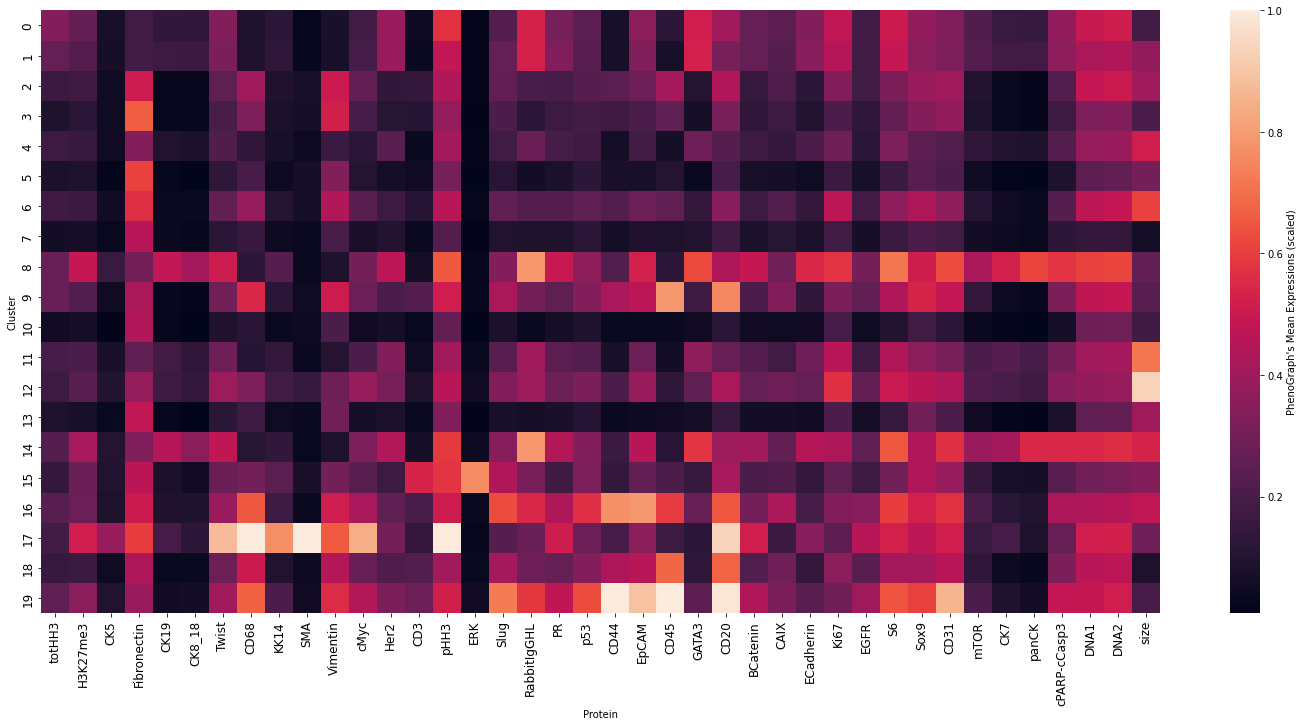

In [31]:
s3 = scaler.transform(pheno_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "PhenoGraph's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [32]:
rf.predict_proba(pheno_centers)[:,0]

array([0.68, 0.92, 0.96, 0.72, 0.98, 0.76, 1.  , 0.3 , 0.54, 0.75, 0.44,
       1.  , 1.  , 0.93, 1.  , 0.89, 0.89, 0.45, 0.27, 0.37])

## FlowSOM

Text(156.0, 0.5, 'Cluster')

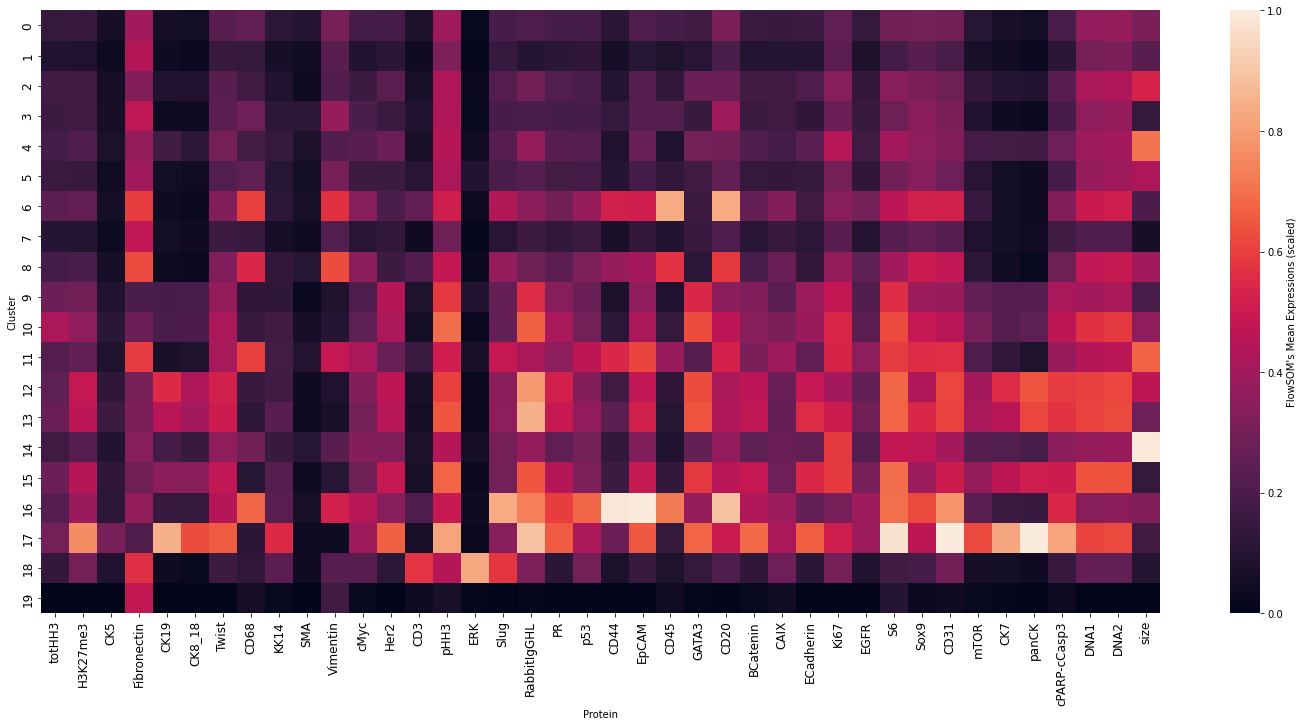

In [33]:
s3 = scaler.transform(fs_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "FlowSOM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [34]:
rf.predict_proba(fs_centers)[:,0]

array([0.98, 0.79, 1.  , 0.57, 1.  , 1.  , 0.64, 0.33, 1.  , 0.55, 0.92,
       0.99, 0.82, 0.72, 1.  , 0.32, 0.6 , 0.28, 0.35, 0.16])

## Kmeans

Text(156.0, 0.5, 'Cluster')

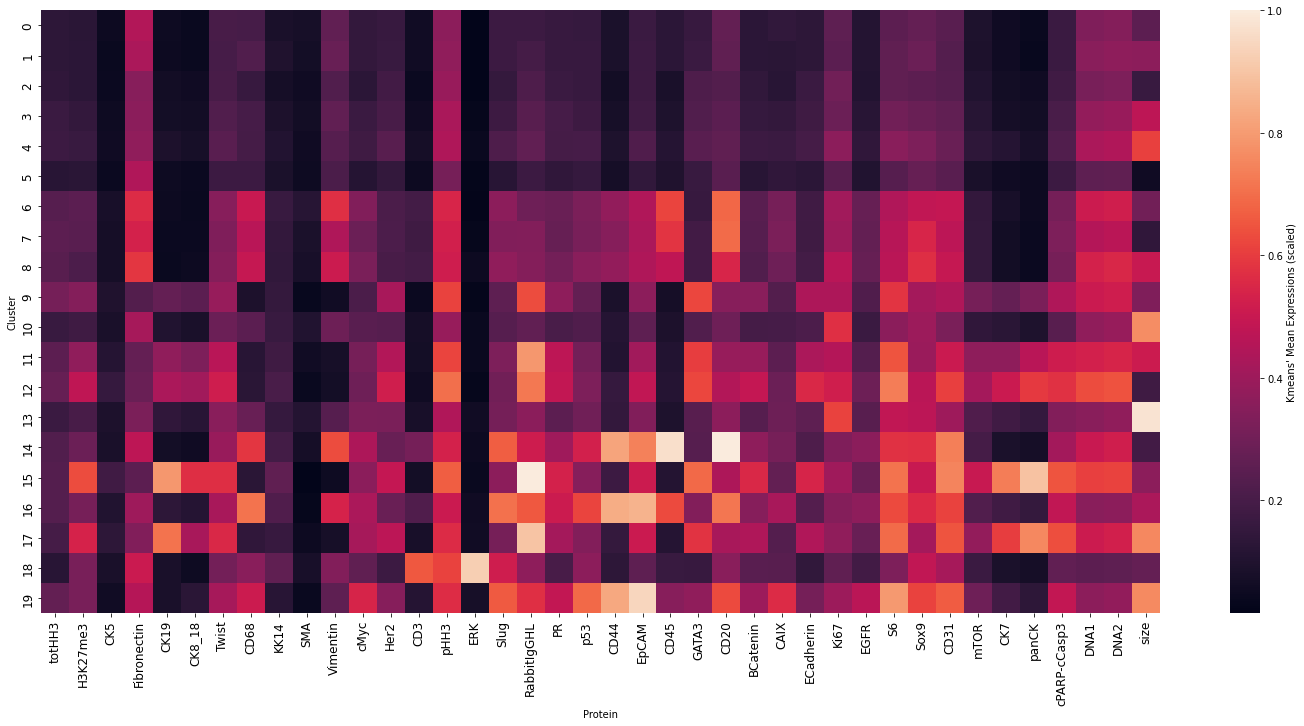

In [35]:
s3 = scaler.transform(okms_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [36]:
rf.predict_proba(okms_centers)[:,0]

array([0.96, 1.  , 0.83, 1.  , 1.  , 0.38, 0.94, 0.53, 0.98, 0.87, 1.  ,
       0.98, 0.34, 1.  , 0.49, 0.49, 0.8 , 0.71, 0.87, 0.92])

# RF on Kmeans

In [37]:
'''
s3 = scaler.transform(okms_centers[singlet_indices])
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "RF on Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")
'''

'\ns3 = scaler.transform(okms_centers[singlet_indices])\nmat = pd.DataFrame(s3, columns = pretty_printing)\nax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={\'label\': "RF on Kmeans\' Mean Expressions (scaled)"})\nax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = \'center\')\nax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = \'center\')\nax.figure.tight_layout()\nplt.xlabel("Protein")\nplt.ylabel("Cluster")\n'

In [38]:
#rf.predict_proba(okms_centers[singlet_indices])[:,0]

## DAMM

Text(156.0, 0.5, 'Cluster')

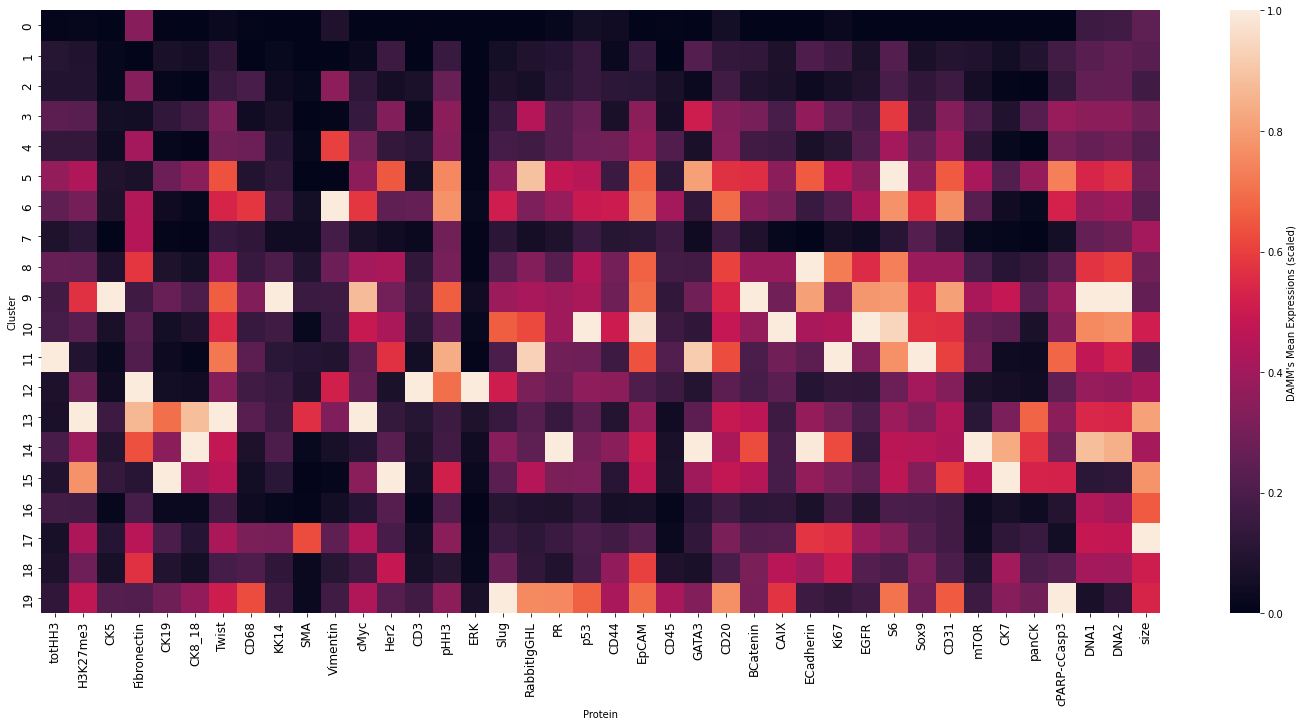

In [39]:
s3 = scaler.transform(damm_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [40]:
rf.predict_proba(damm_centers)[:,0]

array([0.23, 0.16, 0.26, 0.49, 0.39, 0.46, 0.4 , 0.77, 0.45, 0.28, 0.55,
       0.31, 0.8 , 0.47, 0.33, 0.57, 0.95, 0.98, 0.89, 0.81])

# UMAP of PhenoGraph/FlowSOM/Kmeans/DAMM clusters

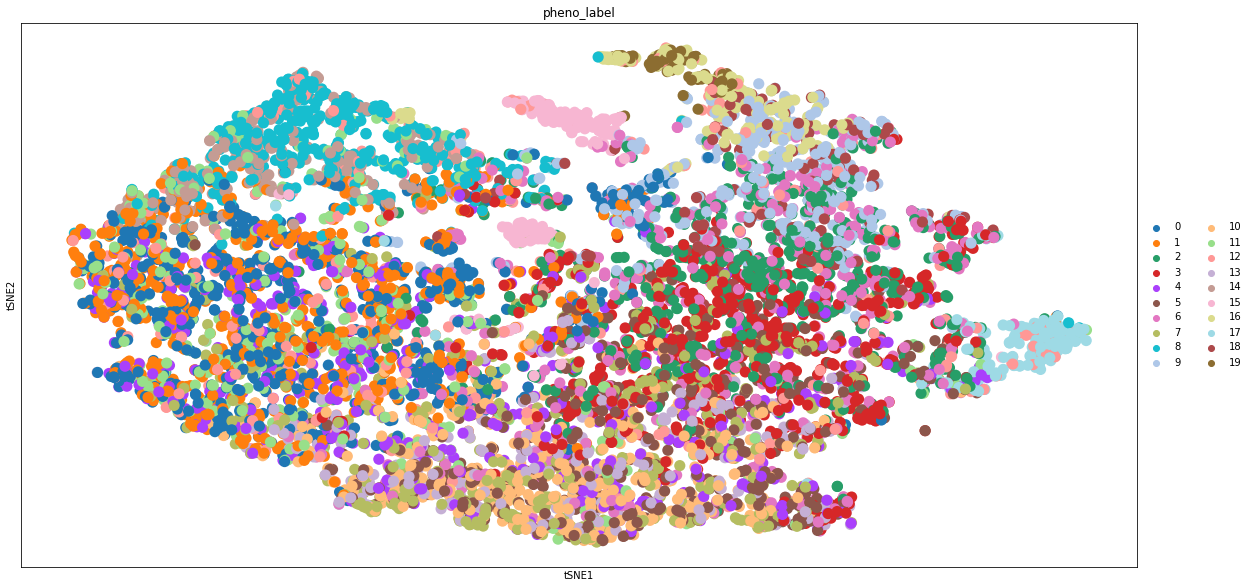

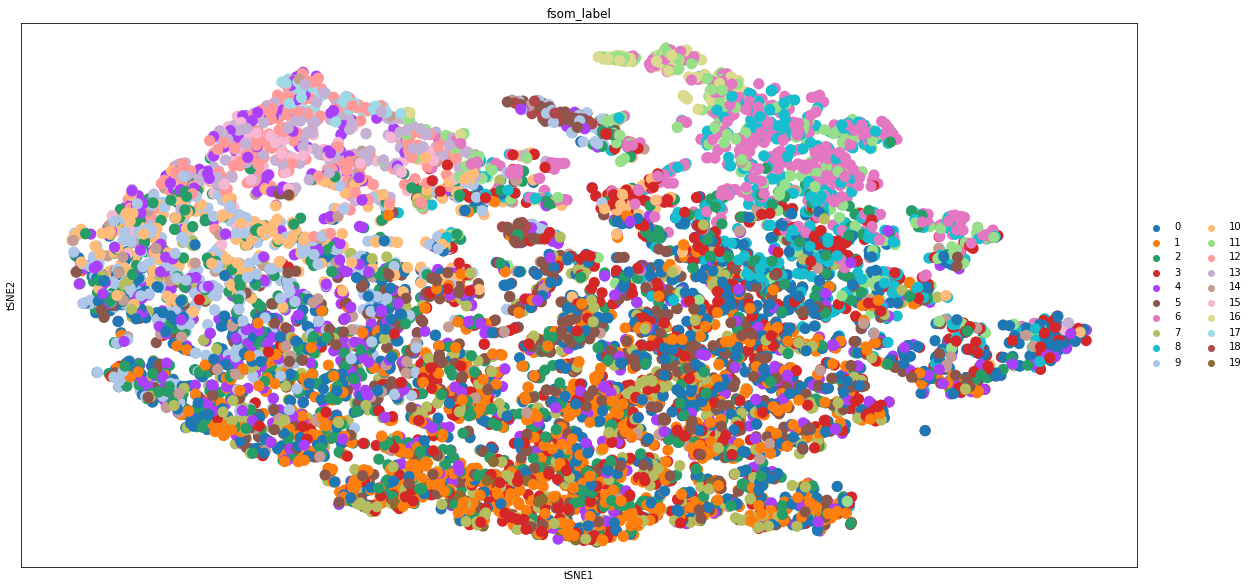

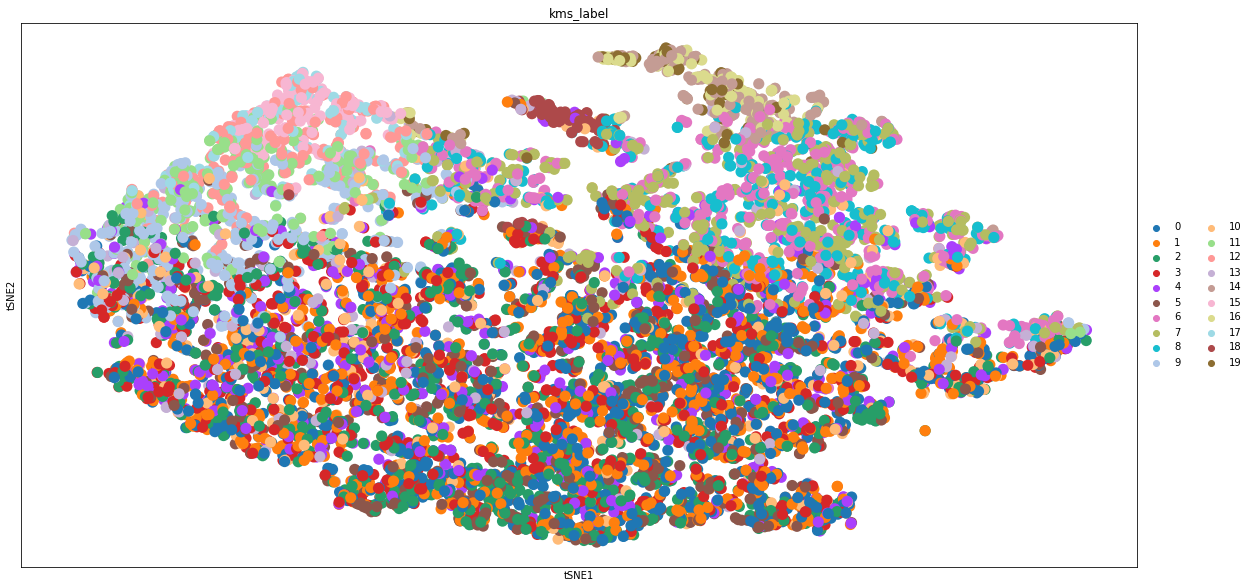

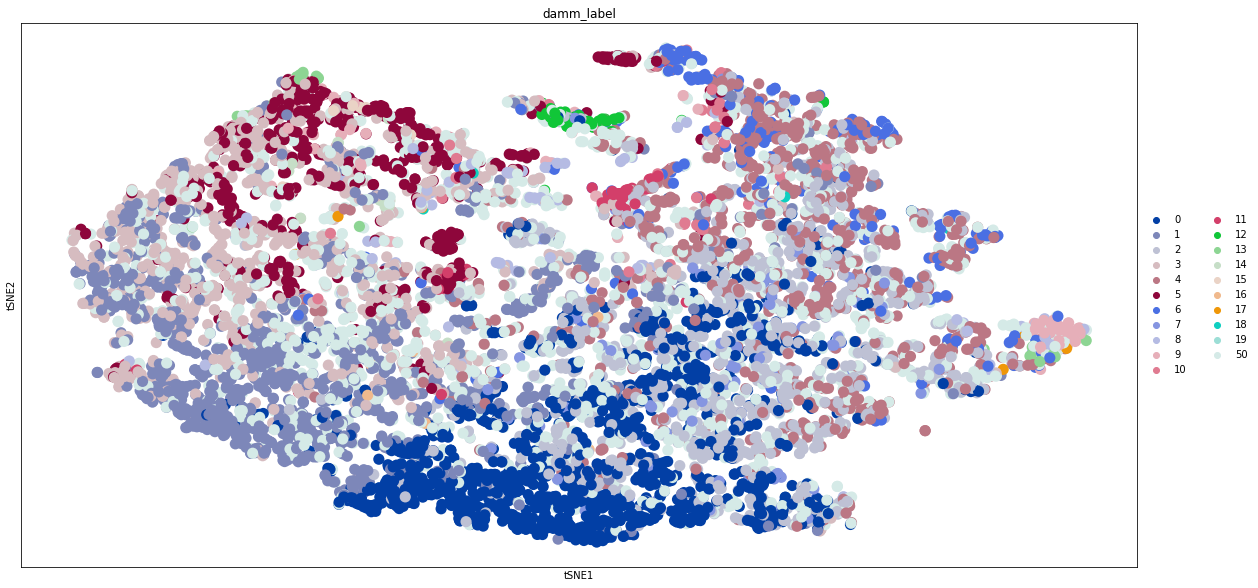

In [41]:
sc.pl.tsne(tr_exp, color="pheno_label", size=500)
sc.pl.tsne(tr_exp, color="fsom_label", size=500)
sc.pl.tsne(tr_exp, color="kms_label", size=500)
sc.pl.tsne(tr_exp, color="damm_label", size=500)

# New Correlation

In [42]:
def newMetric2(mat1, mat2, anti, pairs, thresholds, gp=1):
    out = []
    for pair in pairs:

        x_name = pair[0]; y_name = pair[1]
        #x = np.array(pheno_mat[x_name]); y = np.array(pheno_mat[y_name])
        #x = np.array(damm_mat[x_name]); y = np.array(damm_mat[y_name])
        x1 = np.array(mat1[x_name]); y1 = np.array(mat1[y_name])
        x2 = np.array(mat2[x_name]); y2 = np.array(mat2[y_name])
    
        if anti:
            ## case 1: negative
            score1 = sum((x1 < thresholds[x_name][0]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 < thresholds[x_name][0]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 0])
        else:
            ## case 2: positive
            score1 = sum((x1 > thresholds[x_name][1]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 > thresholds[x_name][1]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 1])
            
        print("{}_{} -- PG: {}; DAMM: {}".format(x_name, y_name, score1, score2))
        
        '''
        plt.scatter(x1, y1)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("PhenoGraph anti: {}".format(anti))
        plt.show()
        
        plt.scatter(x2, y2)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("DAMM anti: {}".format(anti))
        plt.show()
        '''
    if gp:
        out_col = ['pair', 'PhenoGraph', 'DAMM', 'type']
    else:
        out_col = ['pair', 'FlowSOM', 'DAMM', 'type']
    return pd.DataFrame(out, columns = out_col)

In [43]:
thresholds = pd.DataFrame(np.quantile(tr_exp.X, [0.25, 0.75], axis=0), columns = pretty_printing[:-1])

In [44]:
thresholds

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,KK14,SMA,...,EGFR,S6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2
0,3.532321,0.329828,0.069910,1.511289,0.164468,0.119395,0.127443,0.130351,0.071779,0.173820,...,0.221382,1.739189,0.208506,0.063698,0.466592,0.036758,0.198205,0.472602,2.092736,3.969091
1,11.405300,0.759667,0.154433,7.446920,0.795239,1.645456,0.335127,0.477256,0.194966,2.144715,...,0.508938,3.798643,0.906085,0.183445,1.255171,0.225690,14.267048,1.238849,5.298849,10.032758


In [45]:
anti_pairs = [['CD3', 'CD20'], 
              ['CD3', 'CD68'], 
              ['CD3', 'panCK'], 
              ['CD3', 'CD31'],
              ['CD20', 'CD68'], 
              ['CD20', 'panCK'], 
              ['CD20', 'CD31'], 
              ['CD45', 'panCK'], 
              ['panCK', 'Vimentin']]
    
co_pairs = [['CD45', 'CD3'],
            ['CD45', 'CD20'],
            ['CD45', 'CD68'],
            ['panCK', 'CK5'],
            ['panCK', 'CK7'],
            ['panCK', 'CK8_18'],
            ['panCK', 'CK19']]

In [46]:
#!pip install --upgrade matplotlib>=3.3.4

In [47]:
pheno_mat = pd.DataFrame(pheno_centers, columns = pretty_printing)
damm_mat = pd.DataFrame(damm_centers, columns = pretty_printing)
anti = newMetric2(pheno_mat, damm_mat, 1, anti_pairs, thresholds, 1)
co = newMetric2(pheno_mat, damm_mat, 0, co_pairs, thresholds, 1)
df = pd.concat([anti, co])

CD3_CD20 -- PG: 0.0; DAMM: 0.1
CD3_CD68 -- PG: 0.0; DAMM: 0.05
CD3_panCK -- PG: 0.0; DAMM: 0.1
CD3_CD31 -- PG: 0.0; DAMM: 0.1
CD20_CD68 -- PG: 0.0; DAMM: 0.1
CD20_panCK -- PG: 0.0; DAMM: 0.05
CD20_CD31 -- PG: 0.0; DAMM: 0.05
CD45_panCK -- PG: 0.0; DAMM: 0.1
panCK_Vimentin -- PG: 0.0; DAMM: 0.1
CD45_CD3 -- PG: 0.4; DAMM: 0.25
CD45_CD20 -- PG: 0.4; DAMM: 0.25
CD45_CD68 -- PG: 0.4; DAMM: 0.25
panCK_CK5 -- PG: 0.3; DAMM: 0.55
panCK_CK7 -- PG: 0.3; DAMM: 0.5
panCK_CK8_18 -- PG: 0.3; DAMM: 0.5
panCK_CK19 -- PG: 0.3; DAMM: 0.5


Text(0.5, 0.98, 'basel: Correlation Alternative')

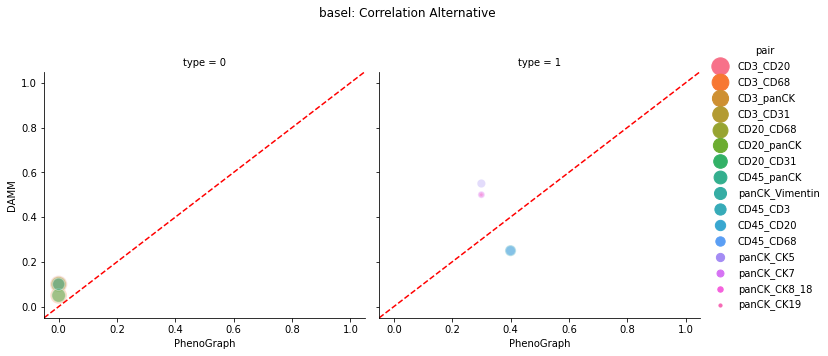

In [48]:
rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

In [49]:
fs_mat = pd.DataFrame(fs_centers, columns = pretty_printing)
anti = newMetric2(fs_mat, damm_mat, 1, anti_pairs, thresholds, 0)
co = newMetric2(fs_mat, damm_mat, 0, co_pairs, thresholds, 0)
df = pd.concat([anti, co])

CD3_CD20 -- PG: 0.05; DAMM: 0.1
CD3_CD68 -- PG: 0.0; DAMM: 0.05
CD3_panCK -- PG: 0.0; DAMM: 0.1
CD3_CD31 -- PG: 0.05; DAMM: 0.1
CD20_CD68 -- PG: 0.05; DAMM: 0.1
CD20_panCK -- PG: 0.05; DAMM: 0.05
CD20_CD31 -- PG: 0.05; DAMM: 0.05
CD45_panCK -- PG: 0.0; DAMM: 0.1
panCK_Vimentin -- PG: 0.0; DAMM: 0.1
CD45_CD3 -- PG: 0.25; DAMM: 0.25
CD45_CD20 -- PG: 0.3; DAMM: 0.25
CD45_CD68 -- PG: 0.25; DAMM: 0.25
panCK_CK5 -- PG: 0.5; DAMM: 0.55
panCK_CK7 -- PG: 0.45; DAMM: 0.5
panCK_CK8_18 -- PG: 0.45; DAMM: 0.5
panCK_CK19 -- PG: 0.5; DAMM: 0.5


Text(0.5, 0.98, 'basel: Correlation Alternative')

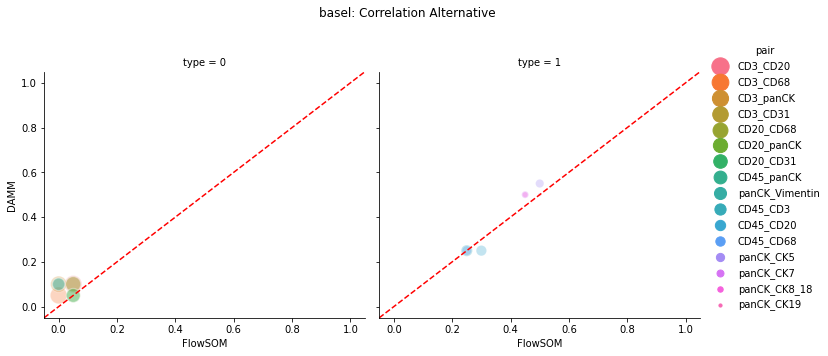

In [50]:
rel = sns.relplot(data=df, x='FlowSOM', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

# ARS of PhenoGraph/FlowSOM/Kmeans/DAMM

In [51]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['fsom_label'])

0.3201637291055731

In [52]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['kms_label'])

0.31230905333264664

In [53]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['damm_label'])

0.09085010285173163

In [54]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['kms_label'])

0.3665113415022835

In [55]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['damm_label'])

0.06938580094503474

In [56]:
adjusted_rand_score(tr_exp.obs['kms_label'], tr_exp.obs['damm_label'])

0.06418932954001899

# Confusion matrix of PG/FS vs DAMM clusters

In [57]:
##remove doublet cells
singlet_set = tr_exp.obs[tr_exp.obs['damm_label'] != '50']

In [58]:
singlet_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8147 entries, BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_89_261_X11Y6_232_a0_3034 to BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_76_201_X14Y5_174_a0_967
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sample        8147 non-null   category
 1   id            8147 non-null   int64   
 2   x             8147 non-null   float64 
 3   y             8147 non-null   float64 
 4   area          8147 non-null   int64   
 5   area_convex   8147 non-null   int64   
 6   pheno_label   8147 non-null   category
 7   fsom_label    8147 non-null   category
 8   kms_label     8147 non-null   category
 9   damm_label    8147 non-null   category
 10  prob_doublet  8147 non-null   float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 506.9+ KB


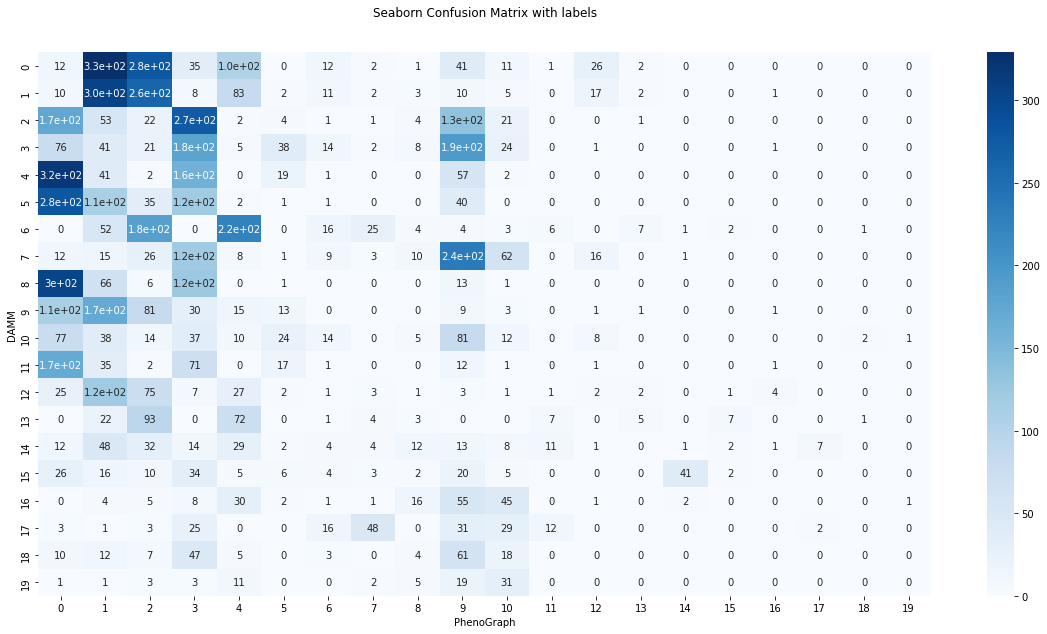

In [59]:
##use singlet cells to compute confusion matrix
cf_mat = confusion_matrix(singlet_set['pheno_label'], singlet_set['damm_label'], labels = singlet_set['pheno_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('PhenoGraph');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

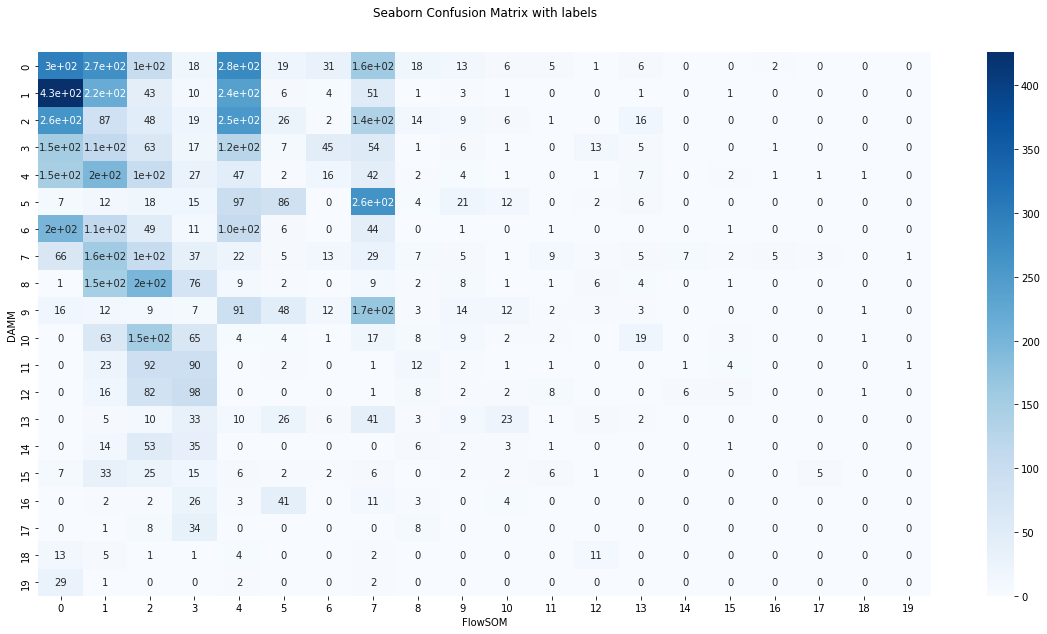

In [60]:
cf_mat = confusion_matrix(singlet_set['fsom_label'], singlet_set['damm_label'], labels = singlet_set['fsom_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('FlowSOM');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Doublet distribution

In [61]:
doublet_set = tr_exp.obs[tr_exp.obs['damm_label'] == '50']

In [62]:
doublet_set['pheno_label'].value_counts()

6     320
2     233
4     226
11    219
12    173
1     130
14     86
0      60
15     57
13     56
16     55
5      50
3      42
8      41
17     39
9      25
10     14
7      12
18     10
19      5
Name: pheno_label, dtype: int64

In [63]:
doublet_set['fsom_label'].value_counts()

4     396
2     356
5     226
11    153
0     147
8     133
14    110
1      66
12     55
10     49
3      48
9      38
6      31
7      14
13     13
16      9
15      7
17      2
18      0
19      0
Name: fsom_label, dtype: int64

# Pinch Effect

In [64]:
#area of convex hull of cell / area of cell

In [65]:
np.mean(singlet_set['area_convex']/singlet_set['area'])

1.1563090845629913

In [66]:
np.mean(doublet_set['area_convex']/doublet_set['area'])

1.1765931847067927

# Cell sizes by cluster

<AxesSubplot:xlabel='cluster', ylabel='size'>

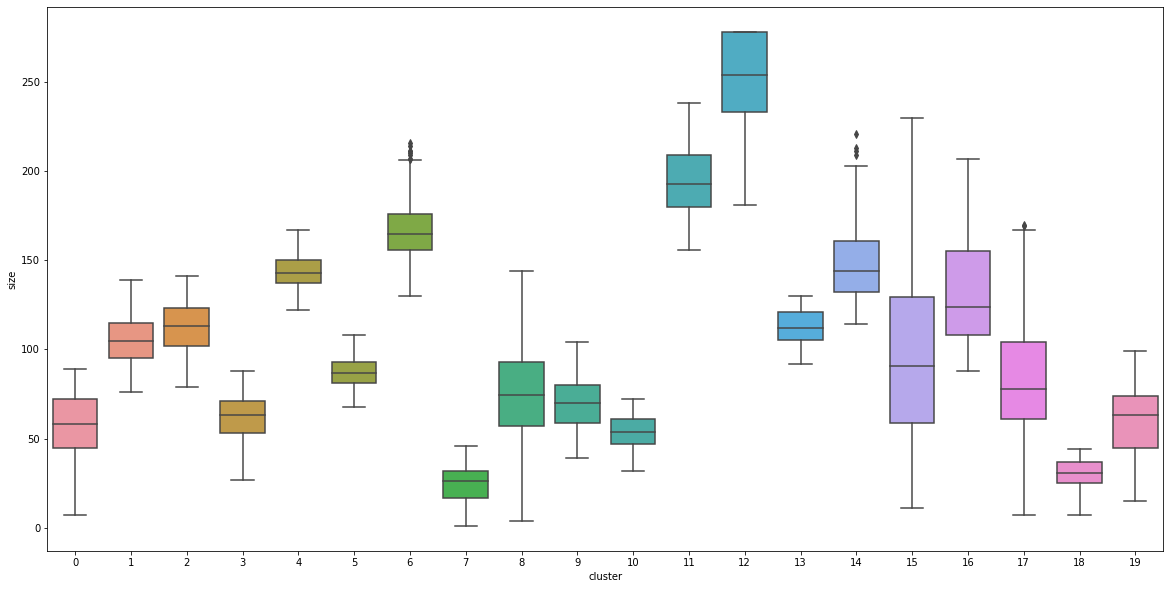

In [67]:
## phenograph
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': pheno_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

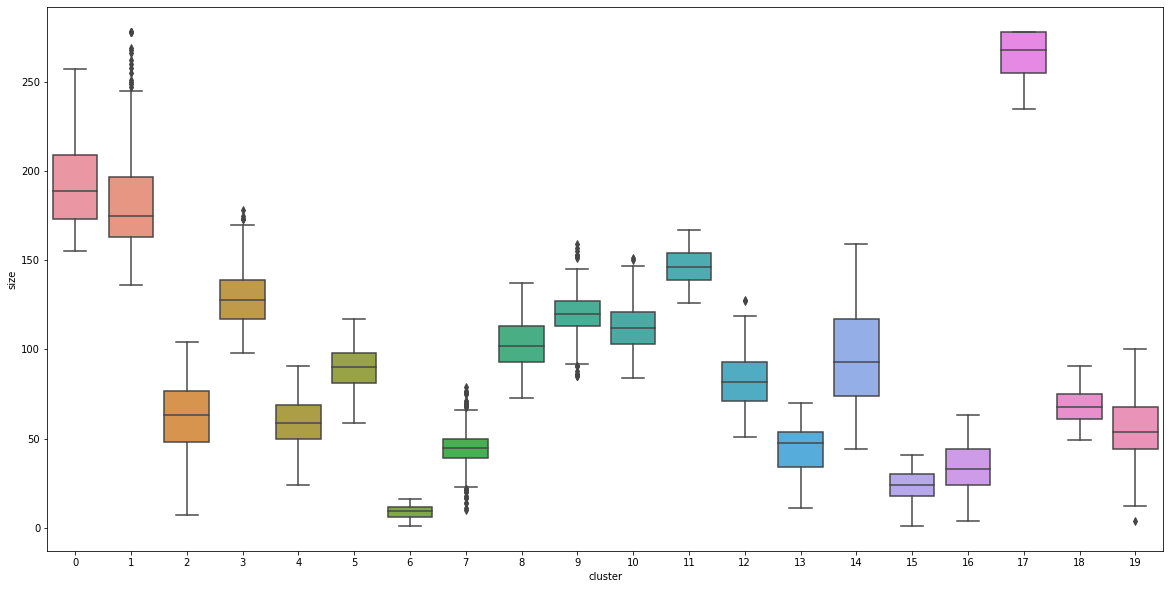

In [68]:
## FlowSOM
d1 = pd.DataFrame({'cluster': fsom_sorted_by_count, 'psi': fs_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': fsom_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

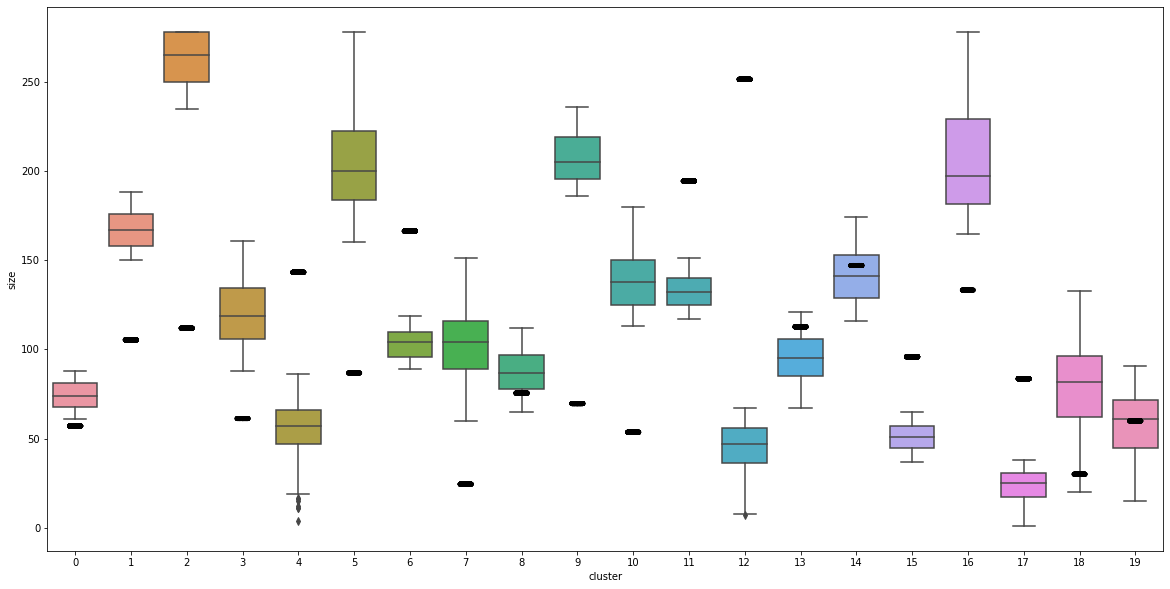

In [69]:
## kmeans
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': okms_labels})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

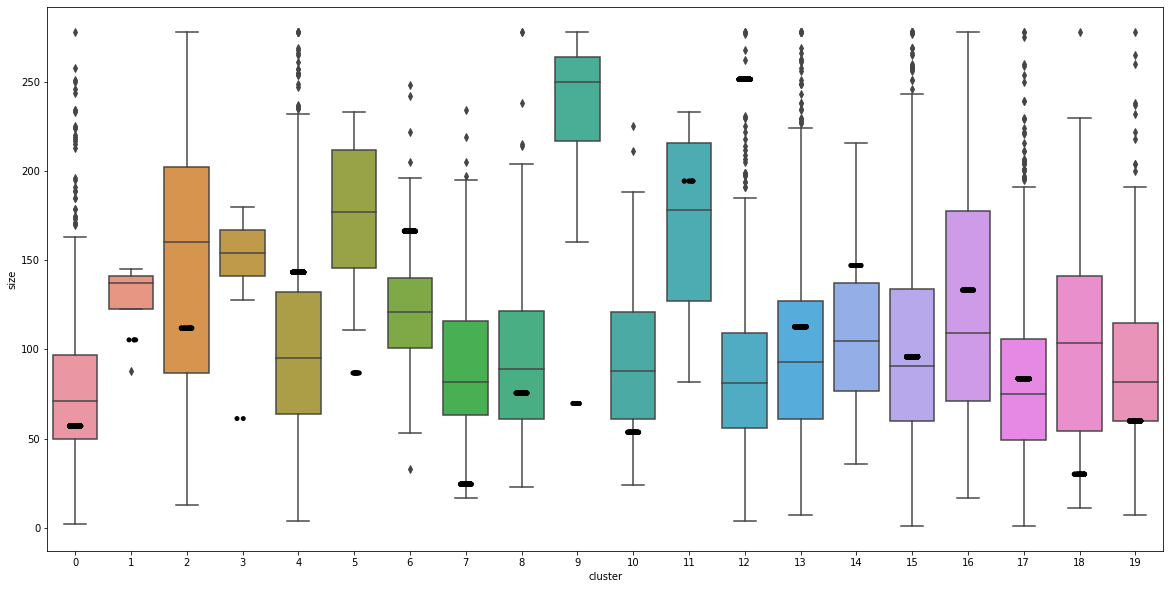

In [70]:
## damm
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': np.array(trS[damm_pred_singlet_label == 0]), 
                   'cluster': damm_pred_singlet_cluster_assig_label})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

In [71]:
'''
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

    pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
        'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
        'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
        'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
        'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']

    analysisProteins = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2', 'size']
    
    analysisProteins = ['TotalHH3', 'H3K27me3', 'Cytokeratin5', 'Fibronectin',
       'Cytokeratin19', 'Cytokeratin8/18', 'Twist', 'CD68', 'Keratin14', 'SMA',
       'Vimentin', 'cMyc', 'cerbB2_Her2', 'CD3', 'phospho_HH3', 'Erk1/2',
       'Slug', 'RabbitIgGHL', 'Progesterone_Receptor_A/B', 'p53', 'CD44',
       'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'Carbonic_Anhydrase_IX',
       'Ecadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'vWF_CD31', 'mTOR',
       'Cytokeratin7', 'panCytokeratin/Keratin_Epithelial',
       'cleavedPARP_CleavedCaspase3', 'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19', 'CK8_18', 'Twist', 'CD68', 'KK14', 'SMA', 'Vimentin', 'cMyc', 
         'Her2', 'CD3', 'pHH3', 'ERK', 'Slug', 'RabbitIgGHL', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3',
         'CD20', 'bCatenin', 'CAIX', 'ECadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK',
         'cPARP-cCasp3', 'DNA1', 'DNA2', 'size']
'''

"\nanalysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',\n       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',\n       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',\n       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',\n       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']\n\n    pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',\n        'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',\n        'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',\n        'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',\n        'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']\n\n    analysisProteins = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',\n                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',\n                'Slug', 'ER', 'PR', 'p